In [18]:
import matplotlib.pyplot as plt
import pprint
import random
import time
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer 
from torchtext.vocab import build_vocab_from_iterator

from fetch_db import reddit_data

In [19]:
subreddit_labels = {1: "askhistorians", 2: "writingprompts", 
                 3: "television", 4: "explainlikeimfive", 
                 5: "lifeprotips", 6: "relationship_advice",
                 7: "science", 8: "books",
                 9: "nba", 10: "philosophy"}

In [20]:
tokenizer = get_tokenizer('basic_english')

In [21]:
mod_data = []
for i in reddit_data:
    title_index = list(subreddit_labels.keys())[list(subreddit_labels.values()).index(i[2])]
    mod_data.append((title_index, i[1]))
    
random.shuffle(mod_data)

In [22]:
train_iter = mod_data[:int(len(mod_data)*0.9)] 
test_iter = mod_data[int(len(mod_data)*0.9):]

In [23]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

In [24]:
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [25]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [27]:
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [28]:
class TextClassificationModel(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_classes)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5 
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [29]:
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [30]:
train_accu = []
train_losses = []

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    
    running_loss = 0
    
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        
        running_loss += loss.item()
        
        if idx % log_interval == 0 and idx > 0:
            elased = time.time() - start_time 
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader), total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
            
        train_loss = running_loss / len(dataloader)
        train_losses.append(train_loss)
        
        train_accu.append(100 * total_acc / total_count)

In [31]:
tick_labels = []
for i in subreddit_labels:
    tick_labels.append(subreddit_labels[i])
    
print(tick_labels)

['askhistorians', 'writingprompts', 'television', 'explainlikeimfive', 'lifeprotips', 'relationship_advice', 'science', 'books', 'nba', 'philosophy']


In [32]:
eval_accu = []
eval_losses = []

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0 
    
    running_loss = 0
    
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            
            running_loss += loss.item()
            
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    
    test_loss = running_loss / len(dataloader)
    eval_losses.append(test_loss)
    
    eval_accu.append(100 * total_acc/total_count)
    return total_acc/total_count

In [33]:
EPOCHS = 10 
LR = 5 
BATCH_SIZE = 64

In [34]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None 
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.90)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val 
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time:  0.10s | valid accuracy    0.233 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  0.07s | valid accuracy    0.344 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  0.07s | valid accuracy    0.400 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  0.07s | valid accuracy    0.444 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  0.09s | valid accuracy    0.533 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  0.07s |

In [35]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('Test accuracy is: {:1.3f}'.format(accu_test))

Checking the results of test dataset.
Test accuracy is: 0.630


In [36]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

# lifeprotips
ex_text_str = 'When your spouse is getting ready and the time to leave is approaching. \
               Instead of reminding them they have 5 minutes left, ask them if you can help with anything.'

model = model.to("cpu")

print("This is from the '%s' subreddit." %subreddit_labels[predict(ex_text_str, text_pipeline)])

This is from the 'lifeprotips' subreddit.


In [37]:
eval_epochs = len(eval_losses)
train_epochs = int((len(train_losses) / eval_epochs) // 1)
train_losses_list = []
eval_losses_list = eval_losses
for i, x in enumerate(train_losses):
    if i % train_epochs == 0 and i > 0 and len(train_losses_list) < eval_epochs:
        train_losses_list.append(x)

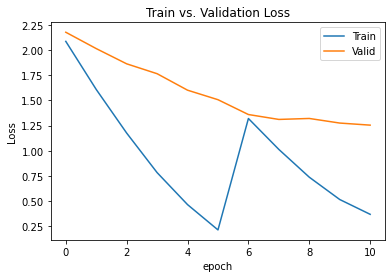

In [38]:
plt.plot(train_losses_list)
plt.plot(eval_losses_list)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs. Validation Loss')
 
plt.show()

In [39]:
eval_epochs = len(eval_accu)
train_epochs = int((len(train_accu) / eval_epochs) // 1)
train_accu_list = []
eval_accu_list = eval_accu
for i, x in enumerate(train_accu):
    if i % train_epochs == 0 and i > 0 and len(train_accu_list) < eval_epochs:
        train_accu_list.append(x)

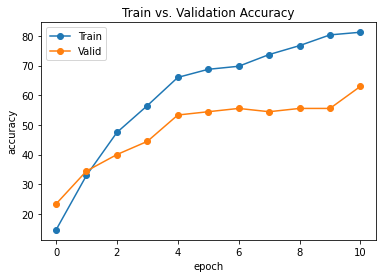

In [40]:
plt.plot(train_accu_list,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs. Validation Accuracy')
 
plt.show()